In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyart

%matplotlib inline

Collis, Scott M

The main field you will be missing is the Normalized Coherent Power, or NCP.. We used this to help determine if we had any second trip returns.. For Nexrad at S-Band this is to much of an issue

You can use this example: https://github.com/openradar/AMS-Short-Course-on-Open-Source-Radar-Software/blob/master/5_Simple_proccessing_and_adding_a_field.ipynb
and just add a nap field with 1.0 everywhere..

Then what you do next is more radar meteorology and less Py-ART :) You can see this example: http://arm-doe.github.io/pyart/dev/auto_examples/correct/plot_lp_phase_proc.html to calculate the KDP

But the default settings are for C-Band.. I have cc-ed in Marcus who has used Py-ART for KDP processing who should be able to share his setup.

In [3]:
radar = pyart.io.read('../../../data/KLWX/KLWX20160730_235503_V06.ar2v')

JJ:
The kdp field specified by the kdp_field argument does not need to exist in the fields of the radar provided and the second returned parameter (sob_kdp) is the calculated specific differential phase, KDP

In [4]:
radar.fields.keys()

['differential_phase',
 'cross_correlation_ratio',
 'spectrum_width',
 'reflectivity',
 'differential_reflectivity',
 'velocity']

and just add a nap field with 1.0 everywhere.

In [5]:
ncp = np.zeros_like(radar.fields['reflectivity']['data'])+1
radar.add_field('normalized_coherent_power', {'data':ncp})

Marcus van Lier-Walqui:

I’ll just share the advice Scott Giangrande gave me on adjusting the LP code for use with S-band. This requires digging into the code and editing some of the values of one of the coefficients. Alternatively, a more general approach would be (as I’ve done) adding those coefficients as keyword arguments, so you can choose their value on the fly.

 - Initially, there should be a variable called "coef" that = 0.914 in that code that is a value more applicable for Cband than Sband... At S-band, it should be lower, e.g., ~0.87. However, since you can also control the "self-Const = 60000", that also can be adjusted to more or less aggressively regulate KDP towards regions of higher Z.
 
 - However, another change might very well be the  'low_z' field. By making this larger, you are effectively also saying that you will be giving preference to locations having Z larger than that value. For S-band, it is feasible that you could get away with raising this potentially as high as 20-30 dBz or more depending on 'how' you wish to use KDP fields... This will also tend to 'steer' better the phase to accumulate only in those locations.

 - Note though, that once you get above the freezing level and in nonrain regions, some of these points above are questionable again.  Since the code does imply a freezing level, that also helps to ensure nothing is applied (I am assuming) using LP methods above that relative altitude.


In [6]:
radar = radar.extract_sweeps([0])

In [8]:
# Perform a Linear programming phase processing to get the conditionally
# fitted phase profile and sobel filtered KDP field

c_offset = 0

# don't bother unwrapping before you are 30 km away from radar
gates = radar.range['data'][1] - radar.range['data'][0]
rge = 30.0 * 1000.0
ng = rge / gates


reproc_phase, sob_kdp = pyart.correct.phase_proc_lp(radar, c_offset, debug=True, nowrap=ng, min_rhv=0.8,coef=0.87, low_z=25)

# in some sectors where there is not enough data the LP method fails.. find these and mask

Unfolding
Exec time:  1.54254508018
Doing  0


In [12]:
reproc_phase['data'][np.where(reproc_phase['data'] < 0.0)] = 0.0
radar.add_field('specific_differential_phase', sob_kdp)
radar.add_field('corrected_differential_phase', reproc_phase)

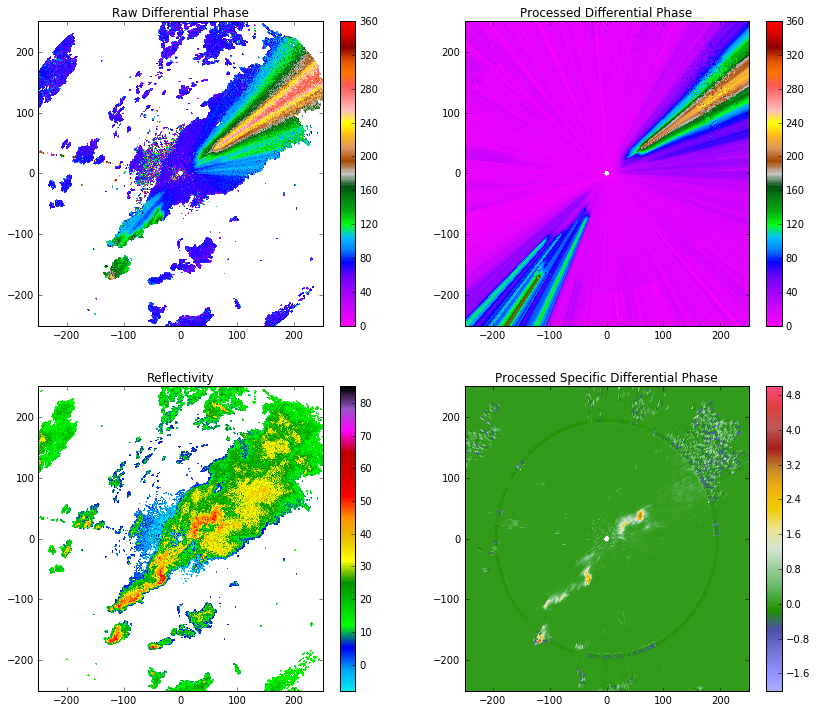

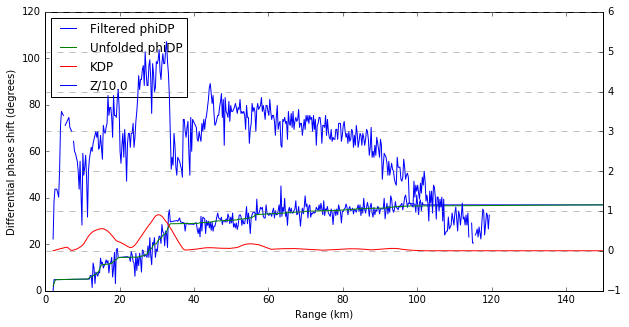

In [13]:
# create a plot of the various differential phase fields
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(14, 12))
ax1 = fig.add_subplot(221)
display.plot('differential_phase', 0, ax=ax1,
             title='Raw Differential Phase', colorbar_label='',
             axislabels_flag=False)
display.set_limits((-250, 250), (-250, 250))

ax2 = fig.add_subplot(222)
display.plot('corrected_differential_phase', 0, ax=ax2, vmax=360,
             title='Processed Differential Phase', colorbar_label='',
             axislabels_flag=False)
display.set_limits((-250, 250), (-250, 250))

ax3 = fig.add_subplot(223)
display.plot('reflectivity', 0, ax=ax3, vmin=-8, vmax=85,
             title='Reflectivity',
             colorbar_label='',
             axislabels_flag=False)
display.set_limits((-250, 250), (-250, 250))

ax4 = fig.add_subplot(224)
display.plot('specific_differential_phase', 0, ax=ax4,
             title='Processed Specific Differential Phase',
             colorbar_label='',
             axislabels_flag=False)
display.set_limits((-250, 250), (-250, 250))
plt.show()

# plot a fields from a single ray
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)
ray_num = 191

# filtered phidp and unfolded phidp
display.plot_ray('unfolded_differential_phase', ray_num, format_str='b-',
                 axislabels_flag=False, title_flag=False, ax=ax)

display.plot_ray('corrected_differential_phase', ray_num, format_str='g-',
                 axislabels_flag=False, title_flag=False, ax=ax)

# set labels
ax.set_ylim(0, 120)
ax.set_ylabel('Differential phase shift (degrees)')
ax.set_xlabel('Range (km)')

# plot KDP and reflectivity on second axis
ax2 = ax.twinx()
display.plot_ray('specific_differential_phase', ray_num, format_str='r-',
                 axislabels_flag=False, title_flag=False, ax=ax2)
try:
    radar.add_field_like('reflectivity', 'scaled_reflectivity',
                         radar.fields['reflectivity']['data']/10.)
except:
    pass
display.plot_ray('scaled_reflectivity', ray_num, format_str='b-',
                 axislabels_flag=False, title_flag=False, ax=ax2)

# decorate
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax.legend(display.plots,
          ["Filtered phiDP", "Unfolded phiDP", 'KDP', 'Z/10.0'],
          loc='upper left')
ax.set_xlim(0,150)
plt.show()

After reading this paper (http://journals.ametsoc.org/doi/full/10.1175/JAM2213.1), it seems that there are a lot of different options for coefficients. Just as an example:

In [14]:
R = 50.7 * radar.fields['specific_differential_phase']['data']**.85

rain_rate_data = np.ma.masked_where((radar.fields['cross_correlation_ratio']['data'] < 0.8), R)
radar.add_field_like('unfolded_differential_phase', 
                     'rain_rate', rain_rate_data)
rainrate = radar.fields['rain_rate']
rainrate['valid_min'] = 0.0
rainrate['valid_max'] = 400.0
rainrate['standard_name'] = 'rainfall_rate'
rainrate['long_name'] = 'rainfall_rate'
rainrate['least_significant_digit'] = 1
rainrate['units'] = 'mm/hr'
rainrate['comment'] = 'Rain rate calculated from kdp, R=50.7*kdp**0.85, note R=0.0 where rhohv < 0.8'

/home/jsignell/miniconda2/envs/pyart/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


/home/jsignell/miniconda2/envs/pyart/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


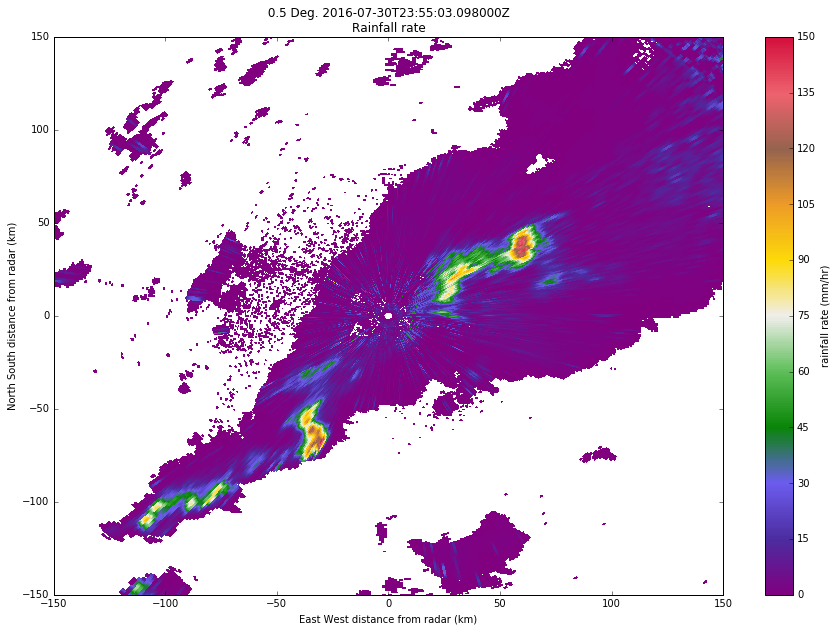

In [15]:
fig = plt.figure(figsize = [15,10])
display.plot_ppi('rain_rate', vmax=150)
display.set_limits((-150, 150), (-150, 150))